# Incidence de la varicelle

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

On télécharge les données depuis le site Web du Réseau Sentinelle sous format csv. 

In [3]:
data_url = "https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

In [5]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202137          7   1984      761    3207       3           1   
1     202136          7   3441     1730    5152       5           2   
2     202135          7   2562     1107    4017       4           2   
3     202134          7   1429      378    2480       2           0   
4     202133          7   3829     1830    5828       6           3   
5     202132          7   4108     1895    6321       6           3   
6     202131          7   4793     2301    7285       7           3   
7     202130          7   7190     4191   10189      11           6   
8     202129          7   6800     4109    9491      10           6   
9     202128          7   9734        0   21731      15           0   
10    202127          7   9026     4316   13736      14           7   
11    202126          7   7284     4108   10460      11           6   
12    202125          7   9351     6540   12162      14          10   
13    202124          7  12034     8937   15131      18          13   
14    202123          7   9116     6420   11812      14          10   
15    202122          7   4817     2752    6882       7           4   
16    202121          7   6092     3458    8726       9           5   
17    202120          7   7485     4601   10369      11           7   
18    202119          7   6654     4370    8938      10           7   
19    202118          7   3912     2110    5714       6           3   
20    202117          7   4686     2878    6494       7           4   
21    202116          7   4780     2891    6669       7           4   
22    202115          7  11215     7627   14803      17          12   
23    202114          7  11197     7994   14400      17          12   
24    202113          7   9714     6289   13139      15          10   
25    202112          7  11520     8415   14625      17          12   
26    202111          7   9386     6678   12094      14          10   
27    202110          7   9056     6452   11660      14          10   
28    202109          7  10988     7938   14038      17          12   
29    202108          7  11281     8361   14201      17          13   
...      ...        ...    ...      ...     ...     ...         ...   
1577  199126          7  17608    11304   23912      31          20   
1578  199125          7  16169    10700   21638      28          18   
1579  199124          7  16171    10071   22271      28          17   
1580  199123          7  11947     7671   16223      21          13   
1581  199122          7  15452     9953   20951      27          17   
1582  199121          7  14903     8975   20831      26          16   
1583  199120          7  19053    12742   25364      34          23   
1584  199119          7  16739    11246   22232      29          19   
1585  199118          7  21385    13882   28888      38          25   
1586  199117          7  13462     8877   18047      24          16   
1587  199116          7  14857    10068   19646      26          18   
1588  199115          7  13975     9781   18169      25          18   
1589  199114          7  12265     7684   16846      22          14   
1590  199113          7   9567     6041   13093      17          11   
1591  199112          7  10864     7331   14397      19          13   
1592  199111          7  15574    11184   19964      27          19   
1593  199110          7  16643    11372   21914      29          20   
1594  199109          7  13741     8780   18702      24          15   
1595  199108          7  13289     8813   17765      23          15   
1596  199107          7  12337     8077   16597      22          15   
1597  199106          7  10877     7013   14741      19          12   
1598  199105          7  10442     6544   14340      18          11   
1599  199104          7   7913     4563   11263      14           8   
1600  199103          7  15387    10484   20290      27          18   
1601  199102          7  16277  

Cherchons les points manquants dans ce jeu de données ? Visiblement aucune sinon une ligne apparaitrait. Fort bien, ca me fait du travail en moins. 

In [6]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Voilà le code qui permettrait d'enlever les données sans valeurs: data = raw_data.dropna().copy()
data

Les données utilisent une convention inhabituelle pour définir le temps qu'il va falloir corriger si nous voulons travailler avec pandas sur ce jeu de données. 

In [9]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data['week']]

Fixons la période de temps comme index et ordonnons par chronologie

In [10]:
sorted_data = raw_data.set_index('period').sort_index()

La il faut vérifier que les périodes ont toutes la même durée, du coup on reprend le code du MOOC:

In [11]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

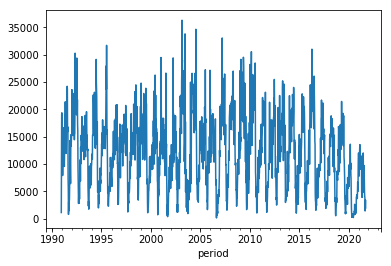

In [12]:
sorted_data['inc'].plot()

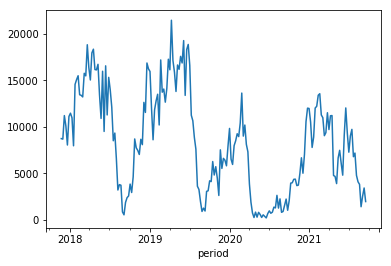

In [13]:
sorted_data['inc'][-200:].plot()

Dans l'entrée 12 j'ai simplement recopié un code qui permet d'avoir une vue d'ensemble sur les données. Etant donné que nous travaillons avec un jeu de donné qui commence en 1991 un zoom sur les dernières années ne fait pas de mal.

Ceci est fait dans l'entrée 13 en ne prenant que les 200 dernières valeurs du jeu de données de la colonne inc.

# Etude de l'incidence annuelle

On peut voir que le pic de l'épidémie se situe en hiver mais commence à la fin de l'été / début de l'automne, du coup nou allons créer des sous périodes d'une durée d'un an en commencant au 1er septembre comme cela nous est demandé dans l'exercice. 

In [16]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

Maintenant il faut s'assurer que ces périodes n'ont pas des durées anormales et soient comprise entre 51 et 52 semaines. 

In [17]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

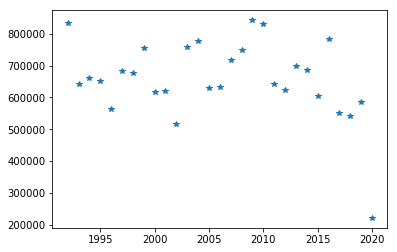

In [18]:
yearly_incidence.plot(style='*')

In [19]:
yearly_incidence.sort_values()

2020    221186
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Les questions du MOOC sont les suivants: 
1) Quelle est l'année avec la plus forte incidence et 2) celle avec la plus faible. 
Simple je n'ai qu'à prendre la dernière et la première valeurs de la liste ci-dessus que sont 2009 et 2020. 

J'ai réussi, Djudjul c'est un thug. Bravo mon vieux. 